In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
import tensorflow as tf

In [3]:
# Verify that you have version 2 of tensorflow

tf.__version__

'2.0.0'

In [1]:
# tf.debugging.set_log_device_placement(True)
# This helps in checking which operations are computed on which device (CPU/ GPU).

In [2]:
import warnings
from h5py.h5py_warnings import H5pyDeprecationWarning
warnings.filterwarnings("ignore", category=H5pyDeprecationWarning)
import h5py
import numpy as np
import pdb
from PIL import Image
import io,os

In [6]:
# Just more ways to check that you're running on GPU and not CPU.

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# tf.test.is_gpu_available(), tf.test.is_built_with_cuda()

In [10]:
tf.keras.backend.set_floatx('float32')

# Dataset

You can download the birds and the flowers dataset from the links mentioned here: https://github.com/aelnouby/Text-to-Image-Synthesis



In [11]:
# The code in this cell is built on top of the code using for extrating the dataset used in this repo:
# https://github.com/aelnouby/Text-to-Image-Synthesis/blob/master/txt2image_dataset.py

class Text2ImageDataset:

    def __init__(self, datasetFile, transform=None, split=0, img_size = 64):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))
        self.img_size = img_size

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()
        return length

    def __getitem__(self, idx):
        img_size = self.img_size
        
        if self.dataset is None:
            self.dataset = h5py.File(self.datasetFile, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]

        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        right_image = np.array(example['img']).tobytes()
        right_embed = np.array(example['embeddings'], dtype=float)

        wrong_image = np.array(self.find_wrong_image(example['class'])).tobytes()
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).convert('RGB')
        wrong_image = Image.open(io.BytesIO(wrong_image)).convert('RGB') # (H, W, C)
        
        #Convert images to tensors
        right_image = tf.keras.preprocessing.image.img_to_array(right_image)
        wrong_image = tf.keras.preprocessing.image.img_to_array(wrong_image)  # (H, W, C)
        
        right_image = tf.convert_to_tensor(right_image)
        wrong_image = tf.convert_to_tensor(wrong_image) # (H, W, C)
        
        # Resize the image tensor - Keeping the aspect ratio constant.
        # The smaller side is transformed to img_size.
        smaller_side = tf.math.minimum(right_image.shape[0], right_image.shape[1])
        right_image = tf.image.resize(right_image, size = (right_image.shape[0]*self.img_size/smaller_side,
                                                           right_image.shape[1]*self.img_size/smaller_side))
        
        smaller_side = tf.math.minimum(wrong_image.shape[0], wrong_image.shape[1])
        wrong_image = tf.image.resize(wrong_image, size = (wrong_image.shape[0]*self.img_size/smaller_side,
                                                           wrong_image.shape[1]*self.img_size/smaller_side)) 
        #(H*img_size/min(H,W), W*img_size/min(H,W), C)
        
        # Random crop to bring to img_size x img_size x C
        right_image = tf.image.random_crop(right_image, size = [img_size, img_size, right_image.shape[2]])
        wrong_image = tf.image.random_crop(wrong_image, size = [img_size, img_size, wrong_image.shape[2]])
        
        
        # Normalize images so that the image is in [-1, 1]
        right_image = (right_image/255. - 0.5)/0.5
        wrong_image = (wrong_image/255. - 0.5)/0.5
        
        # Permute the dimenstions to change (H, W, C) to (C, H, W)
        right_image = tf.keras.backend.permute_dimensions(right_image, pattern = (2, 0, 1)) #(C, 64, 64)
        wrong_image = tf.keras.backend.permute_dimensions(wrong_image, pattern = (2, 0, 1))
        
        a = example['txt'].value
        special = u"\ufffd\ufffd"
        a = a.replace(special,' ')
        txt = np.array(a).astype(str)
        txt = str(txt)
        
        if self.split == 'test':
            name = txt.replace("/", "").replace("\n", "").replace(" ", "_")[:100]        

        return right_image, tf.convert_to_tensor(right_embed), wrong_image, tf.convert_to_tensor(inter_embed), txt

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']


In [15]:
# Download the dataset as mentioned above.
# Define a few configs.

datasetFile = 'flowers.hdf5'
img_size = 64
dataset = Text2ImageDataset(datasetFile)

BUFFER_SIZE = 1000
BATCH_SIZE = 32

model_name = 'ConditionalGAN'


In [1]:
# You should run the below cells just once so that you store the data in a tensor, and write them to a pickle file.
# Reading the data takes some time, so you don't want to do it every time you run the code.

In [16]:
# Read off the images from the dataset and store them in a list.

# right_images = []
# right_embed = []
# wrong_images = []
# wrong_embed = []
# captions = []

# for i in range(dataset.__len__()):
    
#     right_image, r_embed, wrong_image, inter_embed, txt = dataset.__getitem__(i)
#     right_images.append(right_image)
#     right_embed.append(r_embed)
#     wrong_images.append(wrong_image)
#     wrong_embed.append(inter_embed)
#     captions.append(txt)
    
#     if i%100 == 0:
#         print(i)

In [21]:
# Convert the lists to tensors and store them as pickle files.

# right_images_tf = tf.convert_to_tensor(right_images)
# right_embed_tf = tf.convert_to_tensor(right_embed)
# wrong_images_tf = tf.convert_to_tensor(wrong_images)
# wrong_embed_tf = tf.convert_to_tensor(wrong_embed)
# captions_tf = captions

# import pickle

# with open('right_images_flowers.pickle', 'wb') as f:
#     pickle.dump(right_images_tf, f)
    
# with open('right_embed_flowers.pickle', 'wb') as f:
#     pickle.dump(right_embed_tf, f)
    
# with open('wrong_images_flowers.pickle', 'wb') as f:
#     pickle.dump(wrong_images_tf, f)
    
# with open('wrong_embed_flowers.pickle', 'wb') as f:
#     pickle.dump(wrong_embed_tf, f)
    
# with open('captions_flowers.pickle', 'wb') as f:
#     pickle.dump(captions_tf, f)

In [20]:
# Read off the pickle files once you've written them, so that you don't need to process the dataset every time.

import pickle

with open('right_images_flowers.pickle', 'rb') as f:
    right_images_tf = pickle.load(f)
    
with open('right_embed_flowers.pickle', 'rb') as f:
    right_embed_tf = pickle.load(f)
    
with open('wrong_images_flowers.pickle', 'rb') as f:
    wrong_images_tf = pickle.load(f)
    
with open('wrong_embed_flowers.pickle', 'rb') as f:
    wrong_embed_tf = pickle.load(f)
    
with open('captions_flowers.pickle', 'rb') as f:
    captions_tf = pickle.load(f)

In [22]:
# Create the dataset using tf.Dataset

train_dataset = tf.data.Dataset.from_tensor_slices((right_images_tf, right_embed_tf, 
                                                    wrong_images_tf, wrong_embed_tf, 
                                                    captions_tf)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(b'this plant has multiple blue and white stamens that hang just above the white petals.\n', shape=(), dtype=string)
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


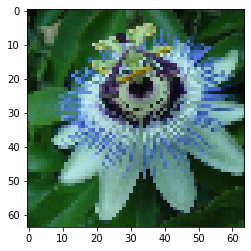

In [23]:
# To verify if you what you have stored is correct and you can restore the image from your data.

for sample in train_dataset:
    right_images, right_embed, wrong_images, inter_embed, captions = sample
    
    image = right_images[0]

    image = tf.keras.backend.permute_dimensions(image, pattern = (1, 2, 0)) #(64, 64, C)
    image = image.numpy()

    image = (image + 1)/2.
    image[image <0] = 0
    image[image >1] = 1

    plt.imshow(image)
    print(captions[0])
    break


In [24]:
# Conditional GAN parameters.
noise_dim = 128
embedding_size = 1024
projected_embedding_size = 256
latent_dim = noise_dim + projected_embedding_size
ngf = 64 # no of Generator features
ndf = 64 # no of Disc features
img_channels = 3
generated_img_size = 64


In [25]:
class Generator(tf.Module):
    def __init__(self):
        super().__init__()
        
        w_init = tf.random_normal_initializer(mean = 0., stddev=0.02) #Weight init for dense layers
        gamma_init = tf.random_normal_initializer(mean = 1., stddev = 0.02) #Weights for Batch Normalization

        # Define the model for projecting the caption to a smaller dimension.
        model = tf.keras.Sequential()
        model.add(layers.Dense(projected_embedding_size, input_shape = (embedding_size, ),
                              kernel_initializer = w_init))
        model.add(layers.BatchNormalization(momentum = 0.1, epsilon = 1e-5, 
                                            gamma_initializer = gamma_init))
        model.add(layers.ReLU()) #(B, projected_embedding_size)

        self.projection = model
        
        # Define the Generator network
        model_1 = tf.keras.Sequential()
        
        model_1.add(layers.Conv2DTranspose(filters = ngf*8, input_shape = (latent_dim, 1, 1),
                                            kernel_size = 4, kernel_initializer = w_init,
                                         strides= 1, padding = 'valid', 
                                              data_format='channels_first', use_bias = False))
        model_1.add(layers.BatchNormalization(epsilon = 1e-5, momentum = 0.1,
                                             gamma_initializer = gamma_init))
        model_1.add(layers.ReLU()) #(B, ngf*8, 4, 4)
        
        
        model_1.add(layers.Conv2DTranspose(filters = ngf*4, kernel_size = 4,
                                         strides= 2, kernel_initializer = w_init,
                                         padding = 'same', data_format='channels_first', use_bias = False))
        model_1.add(layers.BatchNormalization(epsilon = 1e-5, momentum = 0.1,
                                             gamma_initializer = gamma_init))
        model_1.add(layers.ReLU()) # (B, ngf*4, 8, 8)
        
        
        model_1.add(layers.Conv2DTranspose(filters = ngf*2, kernel_size = 4, 
                                         strides= 2, kernel_initializer = w_init,
                                         padding = 'same', data_format='channels_first', use_bias = False))
        model_1.add(layers.BatchNormalization(epsilon = 1e-5, momentum = 0.1,
                                             gamma_initializer = gamma_init))
        model_1.add(layers.ReLU()) # (B, ngf*2, 16, 16)
        
        
        model_1.add(layers.Conv2DTranspose(filters = ngf, kernel_size = 4, 
                                         strides= 2, kernel_initializer = w_init,
                                         padding = 'same', data_format='channels_first', use_bias = False))
        model_1.add(layers.BatchNormalization(epsilon = 1e-5, momentum = 0.1,
                                             gamma_initializer = gamma_init))
        model_1.add(layers.ReLU()) # (B, ngf, 32, 32)
        
        
        model_1.add(layers.Conv2DTranspose(filters = img_channels, kernel_size = 4, 
                                         strides= 2, kernel_initializer = w_init,
                                         padding = 'same', data_format='channels_first', use_bias = False))
        model_1.add(layers.Activation('tanh')) # (B, img_channels, 64, 64)
        
        self.netG = model_1

    def forward(self, embedding, noise, training = True):
        projected_embedding = self.projection(embedding, training = training) # (B, projected_embedding_size)
        noise = noise # (B, noise_dim)
        
        input = tf.keras.backend.concatenate((noise, projected_embedding), axis = 1) #(B, projected_embedding_size + noise_dim)
        input = tf.keras.backend.reshape(input, shape=(input.shape[0], input.shape[1], 1, 1))
        output = self.netG(input, training = training) # (B, img_channels, 64, 64)
        
        return output

In [26]:
class Discriminator(tf.Module):
    def __init__(self):
        super().__init__()
        
        w_init = tf.random_normal_initializer(mean = 0, stddev=0.02)
        gamma_init = tf.random_normal_initializer(mean = 1., stddev = 0.02)
        
        # First part of the Discriminator network.
        model = tf.keras.Sequential() #(B, 64, 64, img_channels)
        model.add(layers.Conv2D(filters = ndf, 
                                input_shape = (generated_img_size, generated_img_size, img_channels),
                                kernel_size = 4,kernel_initializer = w_init,
                                strides= 2, padding = 'same', 
                                data_format='channels_last', use_bias = False))
        model.add(layers.BatchNormalization(epsilon = 1e-5, momentum = 0.1,
                                           gamma_initializer = gamma_init))
        model.add(layers.LeakyReLU(0.2)) #(B, 32, 32, ndf)
        
        
        model.add(layers.Conv2D(filters = ndf*2, kernel_size = 4, kernel_initializer = w_init,
                                strides= 2, padding = 'same', 
                                              data_format='channels_last', use_bias = False))
        model.add(layers.BatchNormalization(epsilon = 1e-5, momentum = 0.1,
                                           gamma_initializer = gamma_init))
        model.add(layers.LeakyReLU(0.2)) #(B, 16, 16, ndf*2)
        
        
        model.add(layers.Conv2D(filters = ndf*4, kernel_size = 4, kernel_initializer = w_init,
                                strides= 2, padding = 'same', 
                                              data_format='channels_last', use_bias = False))
        model.add(layers.BatchNormalization(epsilon = 1e-5, momentum = 0.1,
                                           gamma_initializer = gamma_init))
        model.add(layers.LeakyReLU(0.2)) #(B, 8, 8, ndf*4)
        
        
        model.add(layers.Conv2D(filters = ndf*8, kernel_size = 4, kernel_initializer = w_init,
                                strides= 2, padding = 'same', 
                                              data_format='channels_last', use_bias = False))
        model.add(layers.BatchNormalization(epsilon = 1e-5, momentum = 0.1,
                                           gamma_initializer = gamma_init))
        model.add(layers.LeakyReLU(0.2)) #(B, 4, 4, ndf*8)
        
        self.netD_1 = model
        
        # Projection model
        model_1 = tf.keras.Sequential()
        model_1.add(layers.Dense(projected_embedding_size, input_shape=(embedding_size,),
                                kernel_initializer = w_init))
        model_1.add(layers.BatchNormalization(epsilon = 1e-5, momentum = 0.1,
                                             gamma_initializer = gamma_init))
        model_1.add(layers.LeakyReLU(0.2))
        
        self.projection = model_1

        # Discriminator model 2 - Combining with captions embedding
        model_2 = tf.keras.Sequential()
        model_2.add(layers.Conv2D(filters = 1, input_shape = (4, 4, ndf *8 + projected_embedding_size),
                                            kernel_size = 4, kernel_initializer = w_init,
                                strides= 1, padding = 'valid', 
                                              data_format='channels_last', use_bias = False))
        model_2.add(layers.Activation('sigmoid'))
        
        self.netD_2 = model_2

    def forward(self, embedding, input, training = True):
        projected_embedding = self.projection(embedding, training = training) # (B, projected_embedding_size)
        
        # Repeat caption projections across the batch.
        projected_embedding = tf.keras.backend.reshape(projected_embedding, 
                                                       shape = (1, 1, projected_embedding.shape[0], 
                                                                projected_embedding.shape[1]))
        projected_embedding = tf.keras.backend.repeat_elements(projected_embedding, rep =4, axis = 0)
        projected_embedding = tf.keras.backend.repeat_elements(projected_embedding, rep =4, axis = 1)
        projected_embedding = projected_embedding  # (4, 4, B, projected_embedding_size)
        projected_embedding = tf.keras.backend.permute_dimensions(projected_embedding, pattern = (2, 0, 1, 3)) # (B, 4, 4, projected_embedding_size)

        # input = (B, C, 64, 64)
        input = tf.keras.backend.permute_dimensions(input, pattern = (0, 2, 3, 1)) # (B, 64, 64, C)

        x_intermediate = self.netD_1(input, training = training) # (B, 4, 4, ndf*8)

        output = tf.keras.backend.concatenate((x_intermediate, projected_embedding), axis = 3)  # (B, 4, 4, ndf*8 + projected_embedding_size)

        output = self.netD_2(output, training = training) # (B, 1, 1, 1)
        output = tf.keras.backend.reshape(output, shape= (output.shape[0], ))

        return output, x_intermediate



In [46]:
# Create the generator and Discriminator, and their optimizers.
# Also define the loss criterion.

generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

criterion = tf.keras.losses.BinaryCrossentropy(label_smoothing= 0.1)

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [50]:
def discriminator_loss(criterion, real_output, fake_output, wrong_caption_output):
    
    real_labels = tf.ones_like(real_output)
    fake_labels = tf.zeros_like(fake_output)
    
    real_loss = criterion(real_labels, real_output)
    fake_loss = criterion(fake_labels, fake_output) + criterion(fake_labels, wrong_caption_output)
    
    total_loss = real_loss + fake_loss/2.
    return total_loss

In [51]:
def generator_loss(criterion, fake_output):
    real_labels = tf.ones_like(fake_output)
    
    loss = criterion(real_labels, fake_output)

    return loss

In [52]:
# This function generates an output after each epoch of the generator training and saves it.

def generate_sample_output(generator, test_loader_birds, epoch):
    
    for sample in test_loader_birds:
        right_images_test, right_embed_test, wrong_images_test, inter_embed_test, captions_test = sample
        
        b_size = right_images_test.shape[0]
        noise = tf.random.normal([b_size, noise_dim])
        
        generated_images_test = generator.forward(right_embed_test, noise, training=False) # (B, C, 64, 64)
        
        for image, caption in zip(generated_images_test, captions_test):
            image = tf.keras.backend.permute_dimensions(image, pattern = (1, 2, 0)) #(64, 64, C)
            image = image.numpy()
            
            
#             print(image)
            image = (image + 1)/2.
            image[image <0] = 0
            image[image >1] = 1
            
            plt.imshow(image)
            plt.axis('off')
            plt.title(caption + "_" + str(epoch))
            
            path = os.path.join("./savedOutputs/", 'flowers_2')
            if not os.path.exists(path):
                os.makedirs(path)
            
            plt.savefig(path + "/" + str(epoch) + ".png")
            break
        break
    

In [53]:
# Important things - tf.stop_gradient()
# @tf.function compiles the function - makes it faster to run in TF.

@tf.function
def train_step(right_images, right_embed, wrong_images, wrong_embed, noise, n_train_gen = 1):
    
    with tf.GradientTape() as disc_tape:
        generated_images = generator.forward(right_embed, noise, training=True) #(B, C, 64, 64)

        real_output, _ = discriminator.forward(right_embed, right_images, training = True)
        fake_output, _ = discriminator.forward(right_embed, tf.stop_gradient(generated_images), training = True)
        
        wrong_caption_output, _ = discriminator.forward(wrong_embed, right_images, training = True)
        
        # Disc Losses
        disc_loss = discriminator_loss(criterion, real_output, fake_output, wrong_caption_output)
    
    # Train Disc
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # Train Gen n_train_gen times.
    total_gen_loss = 0.
    for i in range(n_train_gen):
        with tf.GradientTape() as gen_tape:
            generated_images = generator.forward(right_embed, noise, training=True) #(B, C, 64, 64)
            
            ## Pass generated images through the trained disc
            fake_output, _ = discriminator.forward(right_embed, generated_images, training = True)

            # Gen loss
            gen_loss = generator_loss(criterion, fake_output) + \
            tf.reduce_mean(tf.keras.losses.MSE(right_images, generated_images))    
            
            total_gen_loss += gen_loss

        # Train Gen
        gen_variables = generator.trainable_variables

        gradients_of_generator = gen_tape.gradient(gen_loss, gen_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, gen_variables))
    
    total_gen_loss /= n_train_gen
    return total_gen_loss, disc_loss, real_output, fake_output, gradients_of_generator, gradients_of_discriminator
    

In [57]:
# This is to count the len_train_dataset. I've used the value in the next cell after calculating it from here.

count = 0
for dataset_batch in train_dataset:
    count += 1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Executing op Var

Time for epoch 6 is 72.34849524497986 sec
G loss =  tf.Tensor(3.4672356, shape=(), dtype=float32)
D loss =  tf.Tensor(1.356172, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.07282555 0.1346148  0.00659254 0.03144532 0.07928482], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.9779157  0.96789646 0.90195894 0.74804235 0.9168844 ], shape=(5,), dtype=float32)
Time for epoch 7 is 60.20215916633606 sec
G loss =  tf.Tensor(1.6775, shape=(), dtype=float32)
D loss =  tf.Tensor(1.3161961, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.54237866 0.383501   0.6371678  0.7253697  0.6671514 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.78560734 0.6567574  0.7479143  0.57017505 0.59269875], shape=(5,), dtype=float32)
Time for epoch 8 is 60.19739627838135 sec
G loss =  tf.Tensor(1.3159231, shape=(), dtype=float32)
D loss =  tf.Tensor(1.3411803, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.29002005 0.10456836 0.5163

Finished batch1
Real output =  tf.Tensor([0.36485326 0.11351368 0.23310575 0.2747708  0.3596378 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.87353444 0.5344194  0.5806068  0.7947707  0.7149608 ], shape=(5,), dtype=float32)
Time for epoch 28 is 59.80186438560486 sec
G loss =  tf.Tensor(1.4843265, shape=(), dtype=float32)
D loss =  tf.Tensor(1.1529664, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.45429456 0.07952318 0.58619994 0.03362313 0.35600233], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.72685915 0.38322058 0.7985867  0.2066603  0.92928076], shape=(5,), dtype=float32)
Time for epoch 29 is 60.11513662338257 sec
G loss =  tf.Tensor(1.5263594, shape=(), dtype=float32)
D loss =  tf.Tensor(1.148365, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.05543956 0.3716473  0.16852379 0.15362439 0.18817273], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.7860843  0.96157813 0.869897   0.905246   0.9832021 ], shape=(5,)

Finished batch1
Real output =  tf.Tensor([0.26523408 0.3263139  0.08634654 0.04486862 0.12990463], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.73180115 0.18653753 0.8092667  0.9032426  0.6639507 ], shape=(5,), dtype=float32)
Time for epoch 49 is 58.06649923324585 sec
G loss =  tf.Tensor(2.4436905, shape=(), dtype=float32)
D loss =  tf.Tensor(0.97011393, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.17485082 0.10094014 0.05549625 0.8555481  0.82577246], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.40470007 0.8457699  0.49109954 0.8374063  0.8285852 ], shape=(5,), dtype=float32)
Time for epoch 50 is 58.12523865699768 sec
G loss =  tf.Tensor(2.4693406, shape=(), dtype=float32)
D loss =  tf.Tensor(0.97058356, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.7848042  0.7664767  0.98442054 0.18116707 0.3870322 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.24259803 0.5376057  0.8822105  0.3958624  0.7217272 ], shape=(

Finished batch1
Real output =  tf.Tensor([0.0508177  0.10433611 0.7407655  0.88099134 0.68492746], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.1545977  0.13761204 0.4004082  0.43434954 0.2802118 ], shape=(5,), dtype=float32)
Time for epoch 58 is 58.121291399002075 sec
G loss =  tf.Tensor(2.5108583, shape=(), dtype=float32)
D loss =  tf.Tensor(0.9451075, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.35145584 0.6454574  0.82080853 0.05628219 0.6349185 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.23794222 0.52115774 0.8469912  0.5523927  0.46153116], shape=(5,), dtype=float32)
Time for epoch 59 is 58.34381175041199 sec
G loss =  tf.Tensor(2.5363133, shape=(), dtype=float32)
D loss =  tf.Tensor(0.93775195, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.10392582 0.7975042  0.32945275 0.3182971  0.30309063], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.41090834 0.783705   0.7255759  0.7593022  0.39817125], shape=(

Finished batch1
Real output =  tf.Tensor([0.22944349 0.06219241 0.30559957 0.60218763 0.6229475 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.2889558  0.51488394 0.20695913 0.2249499  0.8400726 ], shape=(5,), dtype=float32)
Time for epoch 79 is 58.68153238296509 sec
G loss =  tf.Tensor(2.689754, shape=(), dtype=float32)
D loss =  tf.Tensor(0.8963821, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.27344972 0.45336357 0.573257   0.624496   0.57673967], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.7542379  0.5404711  0.6784381  0.3242913  0.33356005], shape=(5,), dtype=float32)
Time for epoch 80 is 59.1541645526886 sec
G loss =  tf.Tensor(2.6639829, shape=(), dtype=float32)
D loss =  tf.Tensor(0.88438547, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.05911401 0.11696619 0.29172668 0.92131436 0.8467698 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.72630167 0.40775108 0.63176394 0.6765766  0.28763205], shape=(5,)

Finished batch1
Real output =  tf.Tensor([0.7091465  0.7019942  0.478298   0.25843638 0.30062807], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.05705509 0.76959044 0.8896471  0.21854919 0.60931647], shape=(5,), dtype=float32)
Time for epoch 100 is 58.75630164146423 sec
G loss =  tf.Tensor(2.825566, shape=(), dtype=float32)
D loss =  tf.Tensor(0.8513443, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.5854902  0.6985541  0.66108567 0.9628007  0.62885696], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.4627758  0.35724574 0.95697093 0.8935063  0.778532  ], shape=(5,), dtype=float32)
Time for epoch 101 is 58.8148889541626 sec
G loss =  tf.Tensor(2.8343909, shape=(), dtype=float32)
D loss =  tf.Tensor(0.83936304, shape=(), dtype=float32)
Executing op __inference_initialize_variables_20043755 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_20043792 in device /job:localhost/replica:0/task:0/device:GPU

Finished batch1
Real output =  tf.Tensor([0.6137452  0.22100908 0.28935453 0.10153732 0.7867677 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.51078343 0.03240344 0.05914021 0.00726077 0.6600948 ], shape=(5,), dtype=float32)
Time for epoch 109 is 59.854307651519775 sec
G loss =  tf.Tensor(2.8676772, shape=(), dtype=float32)
D loss =  tf.Tensor(0.82528347, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.8550072  0.271631   0.12149996 0.78059447 0.9936341 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.10632515 0.10451034 0.02731496 0.30249286 0.05392364], shape=(5,), dtype=float32)
Time for epoch 110 is 58.51583194732666 sec
G loss =  tf.Tensor(2.8509593, shape=(), dtype=float32)
D loss =  tf.Tensor(0.8368469, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.9163412  0.71865237 0.2891472  0.816466   0.59979   ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.8107853  0.8319578  0.56399006 0.8353764  0.39156467], shape

Finished batch1
Real output =  tf.Tensor([0.75022084 0.8348001  0.5695351  0.95118636 0.6875268 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.02684751 0.76307094 0.37362581 0.7610363  0.2693792 ], shape=(5,), dtype=float32)
Time for epoch 130 is 58.822550535202026 sec
G loss =  tf.Tensor(2.873658, shape=(), dtype=float32)
D loss =  tf.Tensor(0.8051117, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.22352335 0.8325448  0.42413646 0.4202546  0.06542432], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.7670247  0.23451021 0.37556553 0.6770785  0.72538364], shape=(5,), dtype=float32)
Time for epoch 131 is 58.978413820266724 sec
G loss =  tf.Tensor(2.8974576, shape=(), dtype=float32)
D loss =  tf.Tensor(0.80662215, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.2829997  0.88477874 0.4277461  0.15337309 0.60173655], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.8375511  0.20305032 0.3145323  0.4752933  0.61388695], shape

Finished batch1
Real output =  tf.Tensor([0.5942023  0.17388475 0.6077919  0.40158412 0.8322349 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.13744637 0.8141235  0.5242741  0.878713   0.605399  ], shape=(5,), dtype=float32)
Time for epoch 151 is 59.14339804649353 sec
G loss =  tf.Tensor(3.0171714, shape=(), dtype=float32)
D loss =  tf.Tensor(0.78757143, shape=(), dtype=float32)
Executing op __inference_initialize_variables_22404413 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_22404450 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_22404460 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_22404499 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_22404570 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_22404635 in

Finished batch1
Real output =  tf.Tensor([0.68214095 0.36518812 0.19127482 0.58134496 0.10692668], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.4012949  0.16032922 0.24476117 0.18116343 0.20439368], shape=(5,), dtype=float32)
Time for epoch 160 is 59.47421908378601 sec
G loss =  tf.Tensor(3.097451, shape=(), dtype=float32)
D loss =  tf.Tensor(0.7725358, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.7541293  0.66312474 0.8699173  0.18852776 0.16057035], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.1287128  0.09737703 0.23476753 0.19609612 0.66630524], shape=(5,), dtype=float32)
Time for epoch 161 is 59.9911425113678 sec
G loss =  tf.Tensor(3.045052, shape=(), dtype=float32)
D loss =  tf.Tensor(0.7722786, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.47045276 0.94056344 0.26067212 0.9723947  0.417324  ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.57572913 0.64211506 0.6598866  0.9574884  0.7554076 ], shape=(5,)

Finished batch1
Real output =  tf.Tensor([0.99035335 0.7458214  0.9934287  0.97790223 0.99395084], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.1292156  0.04996213 0.04773566 0.00661594 0.01909894], shape=(5,), dtype=float32)
Time for epoch 181 is 59.15397810935974 sec
G loss =  tf.Tensor(3.1880074, shape=(), dtype=float32)
D loss =  tf.Tensor(0.7524964, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.35204875 0.6294424  0.40322363 0.7079596  0.5556702 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.91224647 0.66223127 0.96819806 0.6316874  0.46344736], shape=(5,), dtype=float32)
Time for epoch 182 is 58.877307176589966 sec
G loss =  tf.Tensor(3.127049, shape=(), dtype=float32)
D loss =  tf.Tensor(0.75870687, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.04673851 0.01103604 0.0248763  0.06410331 0.15066585], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.75514686 0.82282966 0.93038654 0.9343177  0.8940326 ], shape=

Executing op __inference_initialize_variables_24765108 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_24765118 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_24765157 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_24765228 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_24765293 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_24765303 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_24765342 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_24765413 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_24765478 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Finished batch1
Real output =  tf.Tensor([0.69359344 0.8308966  0.18812281 0.9425491  0.79415995], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.41693917 0.5035389  0.78891885 0.3469018  0.57152903], shape=(5,), dtype=float32)
Time for epoch 211 is 58.76215958595276 sec
G loss =  tf.Tensor(3.2257254, shape=(), dtype=float32)
D loss =  tf.Tensor(0.7424027, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.5185947  0.98034453 0.95675886 0.9696789  0.913082  ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.08415252 0.38456476 0.28179246 0.13422993 0.07528135], shape=(5,), dtype=float32)
Time for epoch 212 is 59.05807852745056 sec
G loss =  tf.Tensor(3.2340703, shape=(), dtype=float32)
D loss =  tf.Tensor(0.73575705, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.84523726 0.9358937  0.9506607  0.1232515  0.53470534], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.15879148 0.96351373 0.80793667 0.6409928  0.7324391 ], shape=

Finished batch1
Real output =  tf.Tensor([0.3970495  0.94693685 0.29672757 0.69668114 0.6741034 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.16633293 0.31815642 0.24938783 0.23462328 0.1937541 ], shape=(5,), dtype=float32)
Time for epoch 232 is 59.05981516838074 sec
G loss =  tf.Tensor(3.2901545, shape=(), dtype=float32)
D loss =  tf.Tensor(0.7263487, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.9883405  0.83455646 0.9761827  0.99864614 0.76401854], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.26971084 0.07681563 0.33544207 0.33074594 0.0265075 ], shape=(5,), dtype=float32)
Time for epoch 233 is 59.30169653892517 sec
G loss =  tf.Tensor(3.2615373, shape=(), dtype=float32)
D loss =  tf.Tensor(0.72795564, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.67249537 0.7989342  0.9236293  0.6295333  0.29305297], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.9087492  0.5453284  0.6506554  0.28100914 0.41094354], shape=

Executing op __inference_initialize_variables_27125886 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_27125951 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_27125961 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_27126000 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_27126071 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_27126136 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_27126146 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_27126185 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_27126256 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Finished batch1
Real output =  tf.Tensor([0.9435811  0.27065533 0.16586822 0.9467993  0.518231  ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.19020876 0.4841575  0.01691127 0.39471176 0.25147986], shape=(5,), dtype=float32)
Time for epoch 262 is 59.13934946060181 sec
G loss =  tf.Tensor(3.2752454, shape=(), dtype=float32)
D loss =  tf.Tensor(0.7079969, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.6149292  0.5483047  0.9601116  0.65391874 0.4293738 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.46807724 0.18411556 0.6695449  0.6484117  0.5040042 ], shape=(5,), dtype=float32)
Time for epoch 263 is 59.30013561248779 sec
G loss =  tf.Tensor(3.3035512, shape=(), dtype=float32)
D loss =  tf.Tensor(0.709833, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.97063434 0.683694   0.91115236 0.8919624  0.9971558 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.03082296 0.04995498 0.24608809 0.05458525 0.5787564 ], shape=(5

Finished batch1
Real output =  tf.Tensor([0.9625779  0.9600389  0.97457075 0.8649975  0.7271608 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.06848747 0.05645093 0.01435229 0.17155427 0.15262598], shape=(5,), dtype=float32)
Time for epoch 283 is 59.071205615997314 sec
G loss =  tf.Tensor(3.2821634, shape=(), dtype=float32)
D loss =  tf.Tensor(0.71077335, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.95890146 0.9107263  0.64488375 0.6554749  0.8668653 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.1585814  0.20679596 0.2633844  0.5167988  0.23796332], shape=(5,), dtype=float32)
Time for epoch 284 is 59.143635749816895 sec
G loss =  tf.Tensor(3.2734325, shape=(), dtype=float32)
D loss =  tf.Tensor(0.70518804, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.6941852  0.912362   0.93505716 0.9579282  0.7677549 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.5406894  0.30656505 0.22727564 0.14822176 0.5154187 ], sha

Executing op __inference_initialize_variables_29486658 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_29486729 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_29486794 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_29486804 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_29486843 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_29486914 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_29486979 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_29486989 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_29487028 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Finished batch1
Real output =  tf.Tensor([0.77413416 0.9370607  0.94748455 0.98534274 0.9911589 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.11589682 0.11365774 0.29780748 0.48304883 0.6558736 ], shape=(5,), dtype=float32)
Time for epoch 313 is 59.73534631729126 sec
G loss =  tf.Tensor(3.2740636, shape=(), dtype=float32)
D loss =  tf.Tensor(0.714028, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.8760005 0.828268  0.8537835 0.987975  0.6155541], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.119279   0.06981251 0.2027663  0.7094844  0.0411087 ], shape=(5,), dtype=float32)
Time for epoch 314 is 59.41750144958496 sec
G loss =  tf.Tensor(3.2799914, shape=(), dtype=float32)
D loss =  tf.Tensor(0.70415205, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.6585389  0.95839417 0.46446365 0.9955343  0.90417016], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.14992279 0.09191206 0.10166261 0.34852207 0.20543447], shape=(5,), 

Finished batch1
Real output =  tf.Tensor([0.8651632  0.34543604 0.9842566  0.0377461  0.24389333], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.43724218 0.3339798  0.06212437 0.7063837  0.58745295], shape=(5,), dtype=float32)
Time for epoch 334 is 59.48586297035217 sec
G loss =  tf.Tensor(3.2931764, shape=(), dtype=float32)
D loss =  tf.Tensor(0.7013226, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.9798901  0.9928951  0.98907495 0.94918746 0.9555733 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.15026554 0.18814546 0.13500908 0.00455663 0.14261392], shape=(5,), dtype=float32)
Time for epoch 335 is 59.39899039268494 sec
G loss =  tf.Tensor(3.2850463, shape=(), dtype=float32)
D loss =  tf.Tensor(0.7044806, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.97254014 0.9154856  0.6139767  0.9116396  0.8661958 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.47903955 0.07792988 0.21286464 0.15926802 0.2181372 ], shape=(

Executing op __inference_initialize_variables_31847501 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_31847572 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_31847637 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_31847647 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_31847686 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_31847757 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_31847822 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_31847832 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_31847928 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Finished batch1
Real output =  tf.Tensor([0.8992739  0.80729246 0.9815004  0.2835799  0.78664637], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.22111931 0.03708804 0.03248346 0.0515222  0.20663217], shape=(5,), dtype=float32)
Time for epoch 364 is 59.79899549484253 sec
G loss =  tf.Tensor(3.4051552, shape=(), dtype=float32)
D loss =  tf.Tensor(0.684471, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.95099646 0.43403685 0.99382865 0.9431379  0.9139297 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.00626272 0.04811412 0.07173643 0.0316481  0.01624909], shape=(5,), dtype=float32)
Time for epoch 365 is 59.91491436958313 sec
G loss =  tf.Tensor(3.3307893, shape=(), dtype=float32)
D loss =  tf.Tensor(0.69752127, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.9203421  0.84265816 0.8674642  0.9595093  0.7502285 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.11224595 0.1223191  0.53008354 0.3883496  0.01352113], shape=(

Finished batch1
Real output =  tf.Tensor([0.9752384  0.86482257 0.96495605 0.9860357  0.6157928 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.08422694 0.01277554 0.36000955 0.12966928 0.09172055], shape=(5,), dtype=float32)
Time for epoch 385 is 60.117512702941895 sec
G loss =  tf.Tensor(3.3894725, shape=(), dtype=float32)
D loss =  tf.Tensor(0.663989, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.9485302  0.9678726  0.93494356 0.85273623 0.8125366 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.20004737 0.03314209 0.01063401 0.01474029 0.17009088], shape=(5,), dtype=float32)
Time for epoch 386 is 59.7082781791687 sec
G loss =  tf.Tensor(3.4767904, shape=(), dtype=float32)
D loss =  tf.Tensor(0.6862579, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.46079722 0.6753465  0.66814244 0.98171675 0.951572  ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.18491822 0.32329917 0.28652415 0.80005944 0.5697783 ], shape=(5

Executing op __inference_initialize_variables_34208305 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_34208344 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_34208415 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_34208480 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_34208490 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_34208586 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_34208595 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_34208689 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_34208698 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Finished batch1
Real output =  tf.Tensor([0.34131962 0.14045107 0.9336464  0.5687164  0.6569966 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.137748   0.30215138 0.45094866 0.2252886  0.7201107 ], shape=(5,), dtype=float32)
Time for epoch 415 is 60.21631622314453 sec
G loss =  tf.Tensor(3.3133967, shape=(), dtype=float32)
D loss =  tf.Tensor(0.676253, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.9588257  0.92325056 0.99674284 0.9935796  0.9937577 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.3162449  0.04327354 0.4830963  0.17624211 0.18298921], shape=(5,), dtype=float32)
Time for epoch 416 is 60.41295337677002 sec
G loss =  tf.Tensor(3.3559363, shape=(), dtype=float32)
D loss =  tf.Tensor(0.68890893, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.11133841 0.1399157  0.28817666 0.7767341  0.94769305], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.3175999  0.8752011  0.5430681  0.5786679  0.34655112], shape=(

Finished batch1
Real output =  tf.Tensor([0.8248916  0.33598906 0.887387   0.5824992  0.34453893], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.58812267 0.45851824 0.714178   0.12129468 0.16094872], shape=(5,), dtype=float32)
Time for epoch 436 is 60.0358362197876 sec
G loss =  tf.Tensor(3.4707336, shape=(), dtype=float32)
D loss =  tf.Tensor(0.67632973, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.7996284  0.95526266 0.9397484  0.98059756 0.97639775], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.02838284 0.11589789 0.02968127 0.13491976 0.2569156 ], shape=(5,), dtype=float32)
Time for epoch 437 is 61.564491510391235 sec
G loss =  tf.Tensor(3.3832128, shape=(), dtype=float32)
D loss =  tf.Tensor(0.6739384, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.9994908  0.977847   0.85180765 0.9972099  0.9988275 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.9319758  0.48212412 0.3520335  0.8362531  0.7168562 ], shape=

Executing op __inference_initialize_variables_36569148 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_36569244 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_36569253 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_36569347 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_36569356 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_36569450 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_36569459 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_36569553 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_36569562 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Finished batch1
Real output =  tf.Tensor([0.99679387 0.8753779  0.7294655  0.8984479  0.9243299 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.24932411 0.05182832 0.11326531 0.11994159 0.26586044], shape=(5,), dtype=float32)
Time for epoch 466 is 60.418275594711304 sec
G loss =  tf.Tensor(3.4432988, shape=(), dtype=float32)
D loss =  tf.Tensor(0.6719654, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.9816027  0.99214184 0.990728   0.93960077 0.9837394 ], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.26771948 0.3485369  0.19138929 0.0394862  0.25461918], shape=(5,), dtype=float32)
Time for epoch 467 is 60.6847779750824 sec
G loss =  tf.Tensor(3.4625452, shape=(), dtype=float32)
D loss =  tf.Tensor(0.67101914, shape=(), dtype=float32)
Finished batch1
Real output =  tf.Tensor([0.9083253  0.26552325 0.6820347  0.40225965 0.82417893], shape=(5,), dtype=float32)
Fake output =  tf.Tensor([0.009251   0.44976243 0.2817505  0.47184607 0.03307912], shape=

KeyboardInterrupt: 

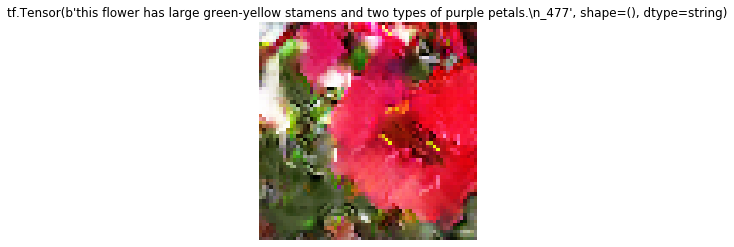

In [59]:
import os

EPOCHS = 1000
start_epoch = 0
n_train_gen = 2
len_train_dataset = count # 2355 for birds, 919 for flowers 

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    i = 0
    
    g_loss_overall = 0.
    d_loss_overall = 0.
    
    for dataset_batch in train_dataset:
        right_images_1, right_embed_1, wrong_images_1, wrong_embed_1, captions_1 = dataset_batch
        
        b_size = right_images_1.shape[0] # Computing batch size again as it may be different for last batch.
        
        # Create a random  noise tensor
        noise = tf.random.normal([b_size, noise_dim])
        
        # Train Step
        g_loss, d_loss, r_output, f_output, g_of_g, g_of_d = train_step(right_images_1, right_embed_1, 
                                                                        wrong_images_1, wrong_embed_1, 
                                                                        noise, n_train_gen)
        
        g_loss_overall += g_loss
        d_loss_overall += d_loss
        
        i += 1
        
        if i == 1:
            print('Finished batch' + str(i))  
            print('Real output = ', r_output[:5])
            print('Fake output = ', f_output[:5])
    

    # Generate an output after each epoch.
    generate_sample_output(generator, train_dataset, epoch)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print('G loss = ', g_loss_overall/len_train_dataset)
    print('D loss = ', d_loss_overall/len_train_dataset)
    
    # Save the generator model after every 50 epochs.
    if (epoch%50 == 0):
        path = './savedModels_Flowers_2'

        if not os.path.exists(path):
            os.makedirs(path)
        generator.netG.save(path + '/Generator_'+str(epoch))
        generator.projection.save(path + '/Projection_'+str(epoch))


In [ ]:
# Things you can try out to increase stability.

# 1. Label smoothing
# 2. Different number of training iterations for generator and discriminator
# 3. Different Learning rates for Gen and Disc.
# 4. Incorporate WGAN type of Loss.

In [2]:
# Testing.
# Load the generator again and use this for generating new images on test dataset.

generator_1 = Generator()
generator_1.netG = tf.keras.models.load_model('./savedModels_Flowers_2/Generator_450')
generator_1.projection = tf.keras.models.load_model('./savedModels_Flowers_2/Projection_450')